In [1]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

In [2]:
save_dir = '/home/jianing/generation/generated'
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
factor = 1.5
adjusted = True
if adjusted:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_factor_%.1f_adjusted.csv'%factor
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split_factor_%.1f'%factor,'adjusted')
else:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_factor_%.1f.csv'%factor
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split_factor_%.1f'%factor)
if not os.path.exists(figure_save_dir):
    os.makedirs(figure_save_dir)

In [4]:
uniform_encoding_dfs = []
for story in stories:
    uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
    # these csv are saved in uniform encoding hypothesis.ipynb
    story_uniform_encoding_df = pd.read_csv(os.path.join(uniform_encoding_save_dir,uniform_encoding_df_name))
    story_uniform_encoding_df['story']=story
    uniform_encoding_dfs.append(story_uniform_encoding_df)
all_uniform_encoding_df = pd.concat(uniform_encoding_dfs,ignore_index= True)
all_uniform_encoding_df=all_uniform_encoding_df.rename(columns={'H(event|prev events)': "H_event_conditioned", "H(event)": "H_event"})

In [8]:
split_by_duration_dfs = []
for story in stories:
    if adjusted:
        pairwise_event_save_dir = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,'story_split_timing_factor_%.1f_adjusted'%factor)
        story_split_by_duration_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'story_split_by_duration_df_adjusted.csv'))
    else:
        pairwise_event_save_dir = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,'story_split_timing_factor_%.1f'%factor)
        story_split_by_duration_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'story_split_by_duration_df.csv'))

        
    segmentation_dir = '/home/jianing/generation/behavior_data/segmentation'
    consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()
    moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
    # tokenized txt 
    with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    consensus_wordlist = segmentation_to_word_list(consensus_txt)
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char=model_initial_char)
    
    num_segmentations = []
    # determine if there's a boundary in the chunk
    for i,row in story_split_by_duration_df.iterrows():
        chunk_start = row['event_starts']
        chunk_end = row['event_ends']
        segmentation_in_chunk = [idx for idx in segmentation_indices_in_tokens[:-1] if idx>=chunk_start and idx < chunk_end]
        num_segmentations.append(len(segmentation_in_chunk))
    num_segmentations = np.array(num_segmentations)
    story_split_by_duration_df['num_boundaries'] = num_segmentations
    story_split_by_duration_df['has_boundary'] = num_segmentations>0
    print(story,'boundary:',np.sum(num_segmentations>0),'non-boundary:',np.sum(num_segmentations==0))
    story_split_by_duration_df['story']=story
    story_split_by_duration_df['event_len']=story_split_by_duration_df['event_ends']-story_split_by_duration_df['event_starts']
    split_by_duration_dfs.append(story_split_by_duration_df)
split_by_duration_dfs=pd.concat(split_by_duration_dfs,ignore_index=True)

pieman boundary: 8 non-boundary: 10
alternateithicatom boundary: 14 non-boundary: 17
odetostepfather boundary: 21 non-boundary: 21
souls boundary: 12 non-boundary: 15
legacy boundary: 16 non-boundary: 15
wheretheressmoke boundary: 12 non-boundary: 13
adventuresinsayingyes boundary: 16 non-boundary: 21
inamoment boundary: 10 non-boundary: 8


In [12]:
assert np.all(all_uniform_encoding_df['event_len'].values ==split_by_duration_dfs['event_len'].values)
all_uniform_encoding_df['story_idx'] = ['Story '+str(story_to_idx_mapping[s]) for s in all_uniform_encoding_df['story'].values]

In [22]:
all_concat_df = pd.concat([split_by_duration_dfs, all_uniform_encoding_df], axis=1)
all_concat_df = all_concat_df.loc[:, ~all_concat_df.columns.duplicated()]
all_concat_df['chunk_type'] = ['Boundary' if i else 'Inner' for i in all_concat_df['has_boundary']]
all_concat_df['word_count'] = all_concat_df['text'].str.split().str.len()
all_concat_df['word_rate'] = all_concat_df['word_count']/all_concat_df['Duration']
all_concat_df['conditioned_info_per_sec'] = all_concat_df['H_event_conditioned']/all_concat_df['Duration']

In [15]:
sns.set_context('paper')

In [24]:
def get_significance(p_val):
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return "ns"
    

                           sum_sq     df          F        PR(>F)
C(chunk_type)            3.309879    1.0  18.018723  3.265399e-05
C(story)                30.863588    7.0  24.002712  6.165298e-24
C(chunk_type):C(story)   0.519647    7.0   0.404131  8.991246e-01
Residual                39.126199  213.0        NaN           NaN


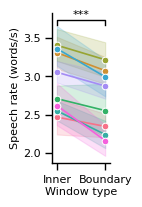

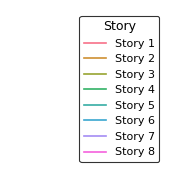

In [61]:
plot_fontsize = 8
# ANOVA
model = ols('word_rate ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)

plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='word_rate', 
             hue='story_idx', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = True)
ax.legend_.remove()
ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Speech rate (words/s)',fontsize = plot_fontsize,labelpad=2)
ax.set_xlim([-0.1,1.1])

x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04 
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)
plt.savefig(os.path.join(figure_save_dir,'word_rate.svg'),transparent = True)



# Extract the legend
handles, labels = ax.get_legend_handles_labels()
# Plot the legend separately
fig1, ax1 = plt.subplots(figsize =(2,2))
plt.legend(handles, labels,fontsize = plot_fontsize,edgecolor='black',title = 'Story',title_fontsize = plot_fontsize+1)
ax1.axis('off')
fig1.savefig(os.path.join(figure_save_dir,'story_idx_legend.svg'),transparent = True)


                             sum_sq     df          F        PR(>F)
C(chunk_type)             28.266794    1.0   4.430683  3.647057e-02
C(story)                 882.403919    7.0  19.758932  2.654925e-20
C(chunk_type):C(story)    40.964767    7.0   0.917290  4.938997e-01
Residual                1358.893820  213.0        NaN           NaN


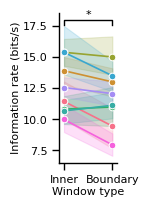

In [62]:
model = ols('conditioned_info_per_sec ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='conditioned_info_per_sec', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)
ax.set_xlim([-0.1,1.1])

x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Information rate (bits/s)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'conditional_info_rate.svg'),transparent = True)

                               sum_sq     df          F        PR(>F)
C(chunk_type)            17079.202607    1.0   5.181679  2.382021e-02
C(story)                250274.825639    7.0  10.847310  1.096102e-11
C(chunk_type):C(story)   21503.157906    7.0   0.931981  4.826205e-01
Residual                702063.935677  213.0        NaN           NaN


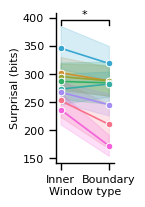

In [27]:
model = ols('H_event_conditioned ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='H_event_conditioned', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Surprisal (bits)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'conditional_info.svg'),transparent = True)

                              sum_sq     df          F        PR(>F)
C(chunk_type)            2412.212913    1.0  22.415066  4.004260e-06
C(story)                10246.518473    7.0  13.601997  1.665118e-14
C(chunk_type):C(story)    567.451913    7.0   0.753278  6.271074e-01
Residual                22922.143070  213.0        NaN           NaN


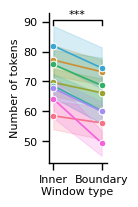

In [30]:
model = ols('event_len ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='event_len', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Number of tokens',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'event_len.svg'),transparent = True)

                             sum_sq     df          F        PR(>F)
C(chunk_type)              2.287579    1.0   1.240281  2.666721e-01
C(story)                1224.068148    7.0  94.809422  6.700347e-62
C(chunk_type):C(story)    33.838148    7.0   2.620912  1.288963e-02
Residual                 392.858054  213.0        NaN           NaN


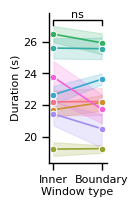

In [34]:
model = ols('Duration ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='Duration', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Duration (s)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'duration.svg'),transparent = True)

                              sum_sq     df         F    PR(>F)
C(chunk_type)              73.643503    1.0  0.432797  0.511330
C(story)                 4779.822439    7.0  4.012952  0.000379
C(chunk_type):C(story)   1302.354484    7.0  1.093406  0.368498
Residual                36243.433689  213.0       NaN       NaN


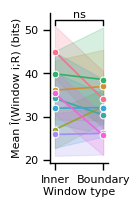

In [31]:
model = ols('mean_ER_intersect ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='mean_ER_intersect', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Mean Î(Window i;R) (bits)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'mean_recalled_info_recall_first.svg'),transparent = True)

                              sum_sq     df          F        PR(>F)
C(chunk_type)             455.993082    1.0   2.710928  1.011376e-01
C(story)                53741.929036    7.0  45.643083  4.323628e-39
C(chunk_type):C(story)   2461.826001    7.0   2.090832  4.578135e-02
Residual                35827.775564  213.0        NaN           NaN


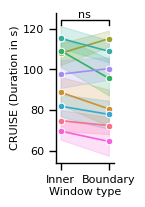

In [63]:
model = ols('weighted_event_info_by_duration ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='weighted_event_info_by_duration', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('CRUISE (Duration in s)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_duration_boundary_inner.svg'),transparent = True)